# Dynamical Decoupling and Randomized Benchmarking on 2 qubit

## Setup

In [47]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

In [48]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [49]:
with open("rename.py") as f:
    exec(f.read())

## Finding pulse duration

Parameters

In [50]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 20e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

A more complete qubit driving Hamiltonian that takes into account the detuning bet is as follows

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( (-I\cos{(\delta \omega t)} + Q\sin{(\delta \omega t)})\sigma_x + (I\sin{(\delta \omega t)}-Q\cos{(\delta \omega t)})\sigma_y)
\end{equation}

where $I = \cos{\phi}$, $Q=\sin{\phi}$ and $\delta \omega$ is the frequency detuning between the pulse frequency and the qubit frequency.

Finding the pulse duration. When specifying Python functions for coefficients, the function must have (t,args) as the input variables, in that order.

In [51]:
def H_solver(t_0 = 0, t_final = 100e-9, init_state = basis(2,0)):
    # Hamiltonian
    def H(t, args):
        dwt = np.random.normal(scale=detuningStd) * t
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
        return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
    
    t_list = np.arange(t_0, t_final, 1/samplingRate)
    result = sesolve(H, init_state, t_list, [sigmaz()],options=Options(nsteps=10000))
    return result

In [29]:
# This code takes 2 minutes to run, maybe sesolve is not optimized for this
t_final = 100e-9
n_steps = int(samplingRate * (t_final - t_0))
t_find_pulse = np.linspace(t_0, t_final, n_steps)
def H_find_pulse(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    # For 2 qubit
    # return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
# For 2 qubit
# result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [tensor(sigmaz(),sigmaz())],options=Options(nsteps=10000))
result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [sigmaz()],options=Options(nsteps=10000))

In [52]:
result_find_pulse = H_solver()

(<Figure size 800x400 with 1 Axes>,
 array([[<Axes: xlabel='time'>]], dtype=object))

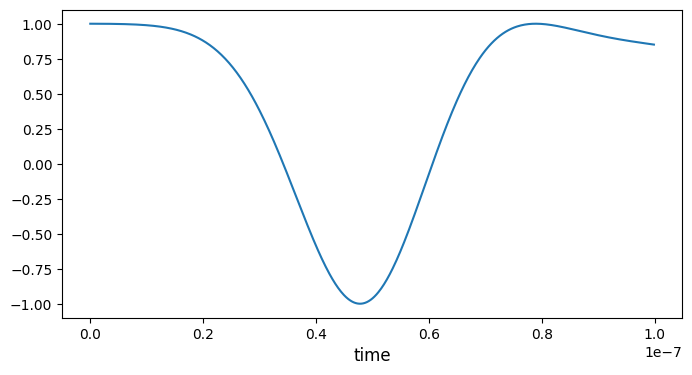

In [53]:
plot_expectation_values(result_find_pulse)

Find the pi-pulse by optimizing

In [54]:
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
first_min = minimum_array[0][0]
pi_pulse_duration = result_find_pulse.times[first_min]
pi_half_pulse_duration = pi_pulse_duration/2
print(pi_pulse_duration,pi_half_pulse_duration)

4.7810872395833335e-08 2.3905436197916668e-08


Solving the Hamiltonian

In [32]:
def H(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / pi_pulse_duration)
    # return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())

In [55]:
result = H_solver(t_final = pi_pulse_duration)

ValueError: x and y must have same first dimension, but have shapes (283,) and (282, 1)

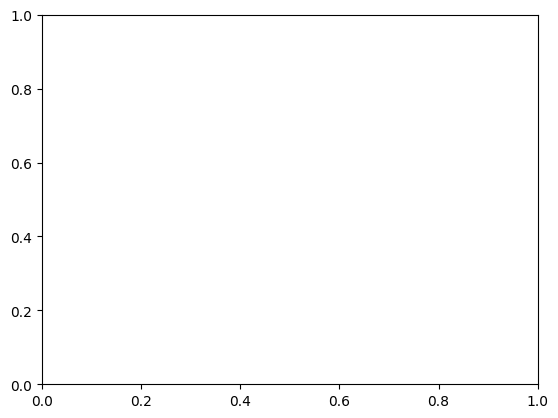

In [56]:
plt.plot(t, np.transpose(result.expect), label=[r"$<\sigma_z>$", r"$<\sigma_x>$", r"$<\sigma_y>$"])
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.legend()

In [ ]:
np.savetxt('pulse_duration.txt',[pi_pulse_duration,pi_half_pulse_duration])